In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/sample_submission.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/train_dataset.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/test_dataset.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/val_dataset.csv


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
import re
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm

nltk.download('punkt')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# === 1. Load Datasets ===
train_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/val_dataset.csv")
test_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/test_dataset.csv")

print(train_df.head())
print(train_df.columns)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


       ID                                               Text  Label
0  189385      @whoisralphie dude  I'm so bummed ur leaving!      0
1   58036  oh my god, a severed foot was foun in a wheely...      0
2  190139  I end up &quot;dog dialing&quot; sumtimes. Wha...      1
3   99313                         @_rachelx meeeee toooooo!       0
4  157825  I was hoping I could stay home and work today,...      0
Index(['ID', 'Text', 'Label'], dtype='object')


In [3]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)     # remove mentions
    text = re.sub(r"[^a-zA-Z']", " ", text)  # keep only letters and apostrophes
    text = text.lower()
    return text

# Apply cleaning
train_df['cleaned'] = train_df['Text'].apply(clean_text)
val_df['cleaned'] = val_df['Text'].apply(clean_text)
test_df['cleaned'] = test_df['Text'].apply(clean_text)

# Tokenization
train_df['tokens'] = train_df['cleaned'].apply(word_tokenize)
val_df['tokens'] = val_df['cleaned'].apply(word_tokenize)
test_df['tokens'] = test_df['cleaned'].apply(word_tokenize)

print(train_df[['Text', 'cleaned', 'tokens']].head())

                                                Text  \
0      @whoisralphie dude  I'm so bummed ur leaving!   
1  oh my god, a severed foot was foun in a wheely...   
2  I end up &quot;dog dialing&quot; sumtimes. Wha...   
3                         @_rachelx meeeee toooooo!    
4  I was hoping I could stay home and work today,...   

                                             cleaned  \
0                    dude  i'm so bummed ur leaving    
1  oh my god  a severed foot was foun in a wheely...   
2  i end up  quot dog dialing quot  sumtimes  wha...   
3                                   meeeee toooooo     
4  i was hoping i could stay home and work today ...   

                                              tokens  
0             [dude, i, 'm, so, bummed, ur, leaving]  
1  [oh, my, god, a, severed, foot, was, foun, in,...  
2  [i, end, up, quot, dog, dialing, quot, sumtime...  
3                                  [meeeee, toooooo]  
4  [i, was, hoping, i, could, stay, home, and, wo..

In [4]:
from gensim.models import Word2Vec

# Φτιάχνουμε λίστα με όλα τα tokenized tweets για training
all_tokens = train_df['tokens'].tolist()

# Εκπαίδευση Word2Vec (100 διαστάσεις)
embedding_dim = 100
w2v_model = Word2Vec(
    sentences=all_tokens,
    vector_size=embedding_dim,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # skip-gram
    seed=SEED
)

# Αποθηκεύουμε το λεξιλόγιο
word2vec = w2v_model.wv
vocab = word2vec.key_to_index
print(f"Vocabulary size: {len(vocab)}")


Vocabulary size: 27351


In [5]:
from torch.nn.utils.rnn import pad_sequence

PAD_IDX = 0
UNK_IDX = 1

# Φτιάχνουμε λεξικό word -> index
word_to_idx = {word: idx + 2 for idx, word in enumerate(word2vec.index_to_key)}
word_to_idx["<PAD>"] = PAD_IDX
word_to_idx["<UNK>"] = UNK_IDX

# Αντίστροφο για debugging
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Δημιουργία embedding matrix
embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
for word, idx in word_to_idx.items():
    if word in word2vec:
        embedding_matrix[idx] = word2vec[word]
    elif word == "<PAD>":
        embedding_matrix[idx] = np.zeros(embedding_dim)
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))


In [6]:
class TweetDataset(Dataset):
    def __init__(self, tokens, labels, word_to_idx, max_len=30):
        self.sequences = [
            [word_to_idx.get(token, UNK_IDX) for token in tokens[i][:max_len]]
            for i in range(len(tokens))
        ]
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]
        seq_tensor = torch.tensor(seq, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return seq_tensor, label_tensor

def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=PAD_IDX)
    return padded_sequences, torch.tensor(labels)

train_dataset = TweetDataset(train_df['tokens'], train_df['Label'].tolist(), word_to_idx)
val_dataset = TweetDataset(val_df['tokens'], val_df['Label'].tolist(), word_to_idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


In [7]:
# === Model definition with dropout and variable hidden layer ===
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.fc1 = nn.Linear(embedding_matrix.shape[1], hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        embedded = self.embedding(x).mean(dim=1)
        out = self.fc1(embedded)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# === Evaluation ===
def evaluate(model, data_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            logits = model(batch_x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_true.extend(batch_y.numpy())
            y_pred.extend(preds)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }

In [8]:
import optuna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# === Optuna objective function ===
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 64, 512)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    model = SentimentClassifier(embedding_matrix, hidden_dim, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(5):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

    metrics = evaluate(model, val_loader)
    return metrics["f1"]

# === Run Optuna ===
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2)

print("Best hyperparameters:", study.best_trial.params)

[I 2025-05-05 16:44:35,189] A new study created in memory with name: no-name-9bb4a065-9786-4f2d-9bf0-35e3c83c3037
[I 2025-05-05 16:51:08,454] Trial 0 finished with value: 0.7833163784333673 and parameters: {'hidden_dim': 88, 'lr': 0.00037214145838531797, 'dropout': 0.23614182198616152}. Best is trial 0 with value: 0.7833163784333673.
[I 2025-05-05 16:56:41,527] Trial 1 finished with value: 0.764988666650061 and parameters: {'hidden_dim': 222, 'lr': 0.02332557837513964, 'dropout': 0.10781052691134835}. Best is trial 0 with value: 0.7833163784333673.


Best hyperparameters: {'hidden_dim': 88, 'lr': 0.00037214145838531797, 'dropout': 0.23614182198616152}


In [9]:
best_params = study.best_trial.params
final_model = SentimentClassifier(embedding_matrix,
                                   hidden_dim=best_params["hidden_dim"],
                                   dropout=best_params["dropout"]).to(device)

def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_f1 = 0
    all_losses = []  # List to store loss values for each epoch
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        all_losses.append(avg_train_loss)  # Save average loss for the epoch

        val_metrics = evaluate(model, val_loader)
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_metrics['accuracy']:.4f} | F1: {val_metrics['f1']:.4f}")

        if val_metrics["f1"] > best_val_f1:
            best_val_f1 = val_metrics["f1"]
            torch.save(model.state_dict(), "best_model.pt")
    
    # Save loss to CSV after training
    loss_df = pd.DataFrame({'Epoch': range(1, num_epochs + 1), 'Loss': all_losses})
    loss_df.to_csv("train_loss.csv", index=False)  # Save the loss values to CSV

train_model(final_model, train_loader, val_loader, num_epochs=3, lr=best_params["lr"])

Epoch 1 | Train Loss: 0.5178 | Val Acc: 0.7875 | F1: 0.7874
Epoch 2 | Train Loss: 0.4384 | Val Acc: 0.7925 | F1: 0.7903
Epoch 3 | Train Loss: 0.4144 | Val Acc: 0.7926 | F1: 0.7947


In [10]:
# Ετοιμασία test set
test_dataset = TweetDataset(test_df['tokens'], [0]*len(test_df), word_to_idx)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Φόρτωση του καλύτερου μοντέλου
final_model.load_state_dict(torch.load("best_model.pt", weights_only=True))
final_model.eval()

# Πρόβλεψη
test_preds = []
with torch.no_grad():
    for batch_x, _ in test_loader:
        batch_x = batch_x.to(device)
        logits = final_model(batch_x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)

# Δημιουργία submission αρχείου
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'Label': test_preds
})
submission.to_csv("submission.csv", index=False)


In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Υπολογισμός των πραγματικών και προβλεπόμενων τιμών για το ROC
y_true = val_df['Label'].tolist()  # Πραγματικά labels
y_pred_prob = []  # Υπολογισμένες πιθανότητες για την κατηγορία "1"
final_model.eval()

with torch.no_grad():
    for batch_x, _ in val_loader:
        batch_x = batch_x.to(device)
        logits = final_model(batch_x)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # Πιθανότητες για την κατηγορία "1"
        y_pred_prob.extend(probs)

# Υπολογισμός ROC καμπύλης και AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Σχεδίαση ROC Curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Διάγωνος γραμμή
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

# Αποθήκευση του ROC Curve σε PDF
plt.savefig("/kaggle/working/roc_curve.pdf")
plt.close()


In [12]:
import matplotlib.pyplot as plt

# Load the loss values from the CSV file
loss_file_name = "train_loss.csv"  # Path to the loss CSV file generated during training
loss_df = pd.read_csv(loss_file_name)  # Load the loss data

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(loss_df['Epoch'], loss_df['Loss'], label='Train Loss', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (Train Loss)')
plt.grid(True)

# Αποθήκευση του Confusion Matrix σε PDF
plt.savefig("/kaggle/working/learning_curve.pdf")
plt.close()


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Υπολογισμός του πίνακα σύγχυσης
y_true = val_df['Label'].tolist()  # Πραγματικά labels
y_pred = []  # Υπολογισμένες προβλέψεις κατηγορίας
final_model.eval()

with torch.no_grad():
    for batch_x, _ in val_loader:
        batch_x = batch_x.to(device)
        logits = final_model(batch_x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.extend(preds)

# Υπολογισμός του Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Σχεδίαση του Confusion Matrix ως heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# Αποθήκευση του Confusion Matrix σε PDF
plt.savefig("/kaggle/working/confusion_matrix.pdf")
plt.close()

Ακρίβεια: 0.7926
Ακρίβεια Θετικών: 0.7866
Ανάκληση: 0.8031
F1 Score: 0.7947


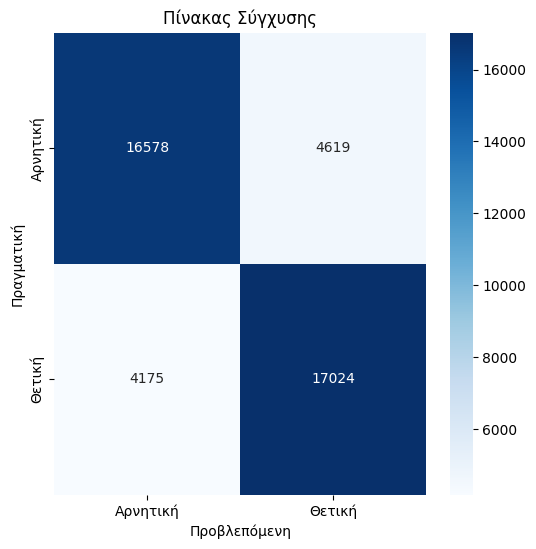

(0.7925747712048307, 0.7865822667837176, 0.8030567479598094, 0.79473413939592)

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Συνάρτηση αξιολόγησης μοντέλου
def evaluate_predictions(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Ακρίβεια: {accuracy:.4f}")
    print(f"Ακρίβεια Θετικών: {precision:.4f}")
    print(f"Ανάκληση: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Υπολογισμός πίνακα σύγχυσης
    cm = confusion_matrix(y_true, y_pred)
    
    # Σχεδίαση heatmap του πίνακα σύγχυσης
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Αρνητική', 'Θετική'], yticklabels=['Αρνητική', 'Θετική'])
    plt.xlabel('Προβλεπόμενη')
    plt.ylabel('Πραγματική')
    plt.title('Πίνακας Σύγχυσης')
    plt.show()

    return accuracy, precision, recall, f1

evaluate_predictions(y_true, y_pred)